# Optimization of a Dissipative State-to-State Transfer in a Lambda System

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import qutip
from qutip import Qobj
import pickle
%watermark -v --iversions

matplotlib.pylab 1.16.2
scipy            1.2.1
qutip            4.3.1
numpy            1.16.2
krotov           0.3.0+dev
matplotlib       3.0.3
CPython 3.6.8
IPython 7.4.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{Ketbra}[2]{\left\vert#1\vphantom{#2}
\right\rangle \hspace{-0.2em} \left\langle #2\vphantom{#1} \right\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}$

This example illustrates the use of Krotov's method with a non-Hermitian
Hamiltonian. It considers the same system as the [previous
example](02_example_lambda_system_rwa_complex_pulse.ipynb), a transition
$\ket{1} \rightarrow \ket{3}$ in a three-level system in a
$\Lambda$-configuration. However, here we add a non-Hermitian decay term to
model loss from the intermediary level $\ket{2}$.

## The effective Hamiltonian

We consider the system as in the following diagram:

![Lambda system considered in this notebook](energylevels.png)

with the Hamiltonian

$$
\Op{H}_{\text{lab}} = \begin{pmatrix}
    E_1                     & -\mu_{12} \epsilon_P(t) & 0                          \\
    -\mu_{12} \epsilon_P(t) & E_2                     & - \mu_{23} \epsilon_S(t) \\
    0                       & -\mu_{23} \epsilon_S(t) &  E_2
\end{pmatrix}
$$

in the lab frame.

However, we now also include that the level $\ket{2}$ decays incoherently. This
is the primary motivation of the STIRAP scheme: through destructive
interference it can keep the dynamics in a "dark state" where the population is
transferred from $\ket{1}$ to $\ket{3}$ without ever populating the $\ket{2}$
state. A rigorous treatment would be to include the dissipation as a Lindblad
operator, and to simulate the dynamics and perform the optimization in
Liouville space. The Lindblad operator for spontaneous decay from level
$\ket{2}$ with decay rate $2\gamma$ is $\Op{L} = \sqrt{2\gamma} \Ketbra{1}{2}$.
However, this is numerically expensive. For the optimization,
it is sufficient to find a way to penalize population in the $\ket{2}$ state.

Motivated by the [Monte-Carlo Wave Function
(MCWF)](https://en.wikipedia.org/wiki/Quantum_jump_method) method, we define
the non-Hermitian *effective Hamiltonian*

$$
\Op{H}_{\text{eff}} = \Op{H}_{\text{lab}} - \frac{i}{2} \Op{L}^{\dagger} \Op{L}
$$

In explicit form, this is

$$
\Op{H}_{\text{lab}} = \begin{pmatrix}
    E_1                     & -\mu_{12} \epsilon_P(t) & 0                          \\
    -\mu_{12} \epsilon_P(t) & E_2 - i \gamma          & - \mu_{23} \epsilon_S(t)   \\
    0                       & -\mu_{23} \epsilon_S(t) &  E_2
\end{pmatrix}
$$

The only change is that the energy of level $\ket{2}$ now has an imaginary part
$-\gamma$, which causes an exponential decay of any population amplitude in
$\ket{2}$, and thus a decay in the norm of the state. In the MCWF, this decay
of the norm is used to track the probability that quantum jump occurs
(otherwise, the state is re-normalized). Here, we do not perform quantum jumps
or renormalize the state. Instead, we use the decay in the norm to steer the
optimization: Using using the functional

$$
J_{T, \text{re}} = 1 - \Re{\Braket{\Psi(T)}{\Psi^{\tgt}}}
$$

to be minimized, we find that the value of
the functional increases if $\Norm{\ket{\Psi(T)}} < 1$. Thus, population in
$\ket{2}$ is penalized, without any significant numerical overhead.

The decay rate $2\gamma$ does not necessarily need to correspond to the actual
physical lifetime of the $\ket{2}$ state: we can choose an artificially high
decay rate to put a stronger penalty on the $\ket{2}$ level. Or, if the
physical decay is so strong that the norm of the state reaches effectively
zero, we could decrease $\gamma$ to avoid numerical instability. The use of a
non-Hermitian Hamiltonian with artificial decay is generally a useful trick to
penalize population in a subspace.

The new non-Hermitian decay term remains unchanged when we make the rotating
wave approximation. The RWA Hamiltonian now reads

$$
\Op{H}_{\text{RWA}} = \begin{pmatrix}
    \Delta_P                    & -\frac{1}{2} \Omega_P(t)   & 0                          \\
    -\frac{1}{2} \Omega_P^*(t)  & -i \gamma                  &  -\frac{1}{2} \Omega_S(t)  \\
    0                           & -\frac{1}{2} \Omega_S^*(t) & \Delta_S
\end{pmatrix}\,,
$$

with complex control fields $\Omega_P(t)$ and $\Omega_S(t)$, see the [previous
example](02_example_lambda_system_rwa_complex_pulse.ipynb). Again, we split
these complex pulses into an independent real and imaginary part for the
purpose of optimization.

The guess controls are

In [2]:
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=2.0, t_stop=5.0)


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=3.0)


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

and the Hamiltonian is instantiated as

In [3]:
def hamiltonian(E1=0.0, E2=10.0, E3=5.0, omega_P=9.5, omega_S=4.5, gamma=0.5):
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    ΔP = E1 + omega_P - E2
    ΔS = E3 + omega_S - E2

    H0 = Qobj([[ΔP, 0.0, 0.0], [0.0, -1j * gamma, 0.0], [0.0, 0.0, ΔS]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]


In [4]:
H = hamiltonian()

We check the hermiticity of the Hamiltonian:

In [5]:
print("H0 is Hermitian: " + str(H[0].isherm))
print("H1 is Hermitian: "+ str(
        H[1][0].isherm
    and H[2][0].isherm
    and H[3][0].isherm
    and H[4][0].isherm))

H0 is Hermitian: False
H1 is Hermitian: True


## Define the optimization target

We optimize for the phase-sensitive transition $\ket{1} \rightarrow \ket{3}$.
As we are working in the rotating frame, the target state must be adjusted with
an appropriate phase factor:

In [6]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

def rwa_target_state(ket3, E2=10.0, omega_S=4.5, T=5):
    return np.exp(1j * (E2 - omega_S) * T) * ket3

psi_target = rwa_target_state(ket3)

The objective is now instantiated as

In [7]:
objectives = [krotov.Objective(initial_state=ket1, target=psi_target, H=H)]

## Simulate dynamics under the guess field

We use a time grid with 500 steps between $t=0$ and $T=5$:

In [8]:
tlist = np.linspace(0, 5, 500)

We propagate once for the population dynamics, and once to obtain the
propagated states for each point on the time grid:

In [9]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)

guess_dynamics = objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3]
)
guess_states = objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm
)

In [10]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.axhline(y=1.0, color='black', lw=0.5, ls='dashed')
    ax.axhline(y=0.0, color='black', lw=0.5, ls='dashed')
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)


def plot_norm(result):

    state_norm = lambda i: result.states[i].norm()
    states_norm=np.vectorize(state_norm)

    fig, ax = plt.subplots()
    ax.plot(result.times, states_norm(np.arange(len(result.states))))
    ax.set_xlabel('time')
    ax.set_ylabel('state norm')
    plt.show(fig)

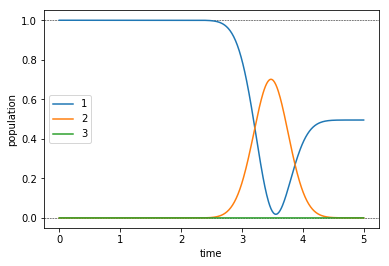

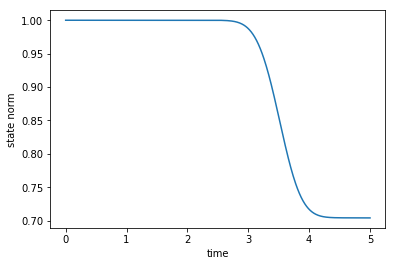

In [11]:
plot_population(guess_dynamics)
plot_norm(guess_states)

The population dynamics and the norm-plot show the effect the non-Hermitian
term in the Hamiltonian, resulting in a 30% loss.

## Optimize

For each control, we define the update shape and the $\lambda_a$ parameter that
determines the magnitude of the update:

In [12]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0.0, t_stop=5.0, t_rise=0.3, func='sinsq'
    )

In [13]:
pulse_options = {
    H[1][1]: dict(lambda_a=2.0, shape=S),
    H[2][1]: dict(lambda_a=2.0, shape=S),
    H[3][1]: dict(lambda_a=2.0, shape=S),
    H[4][1]: dict(lambda_a=2.0, shape=S)
}

We now run the optimization for 40 iterations, printing out the fidelity

$$
F_{\text{re}} = \Re{\Braket{\Psi(T)}{\Psi^{\tgt}}}
$$

after each iteration.

In [14]:
def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("   F = %f" % F_re)
    return F_re

In [15]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity,
    iter_stop=40
)

   F = -0.007812
   F = 0.055166
   F = 0.117604
   F = 0.178902
   F = 0.238507
   F = 0.295926
   F = 0.350749
   F = 0.402648
   F = 0.451388
   F = 0.496822
   F = 0.538882
   F = 0.577573
   F = 0.612961
   F = 0.645161
   F = 0.674324
   F = 0.700629
   F = 0.724268
   F = 0.745445
   F = 0.764364
   F = 0.781226
   F = 0.796224
   F = 0.809541
   F = 0.821349
   F = 0.831809
   F = 0.841064
   F = 0.849250
   F = 0.856486
   F = 0.862881
   F = 0.868532
   F = 0.873527
   F = 0.877942
   F = 0.881847
   F = 0.885302
   F = 0.888362
   F = 0.891074
   F = 0.893481
   F = 0.895618
   F = 0.897519
   F = 0.899211
   F = 0.900721
   F = 0.902071


We look at the optimized controls and the population dynamics they induce:

pump pulse amplitude and phase:


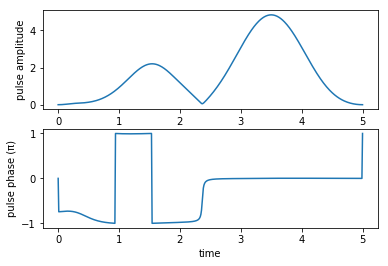

Stokes pulse amplitude and phase:


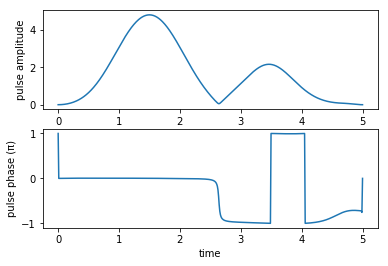

In [16]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()

print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist)

We check the evolution of the population due to our optimized pulses.

In [17]:
opt_dynamics = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3])
opt_states = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm)

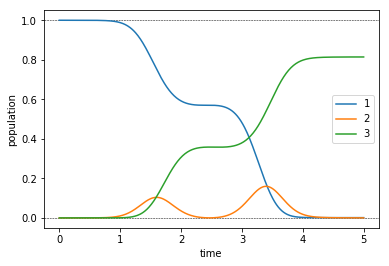

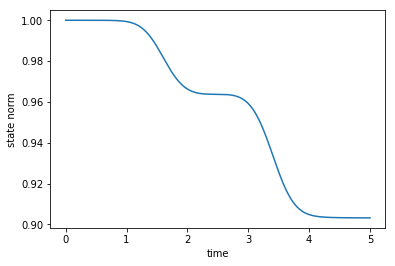

In [18]:
plot_population(opt_dynamics)
plot_norm(opt_states)

These dynamics show that the non-Hermitian Hamiltonian has the desired effect:
The population is steered out of the decaying $\ket{2}$ state, with the
resulting loss in norm down to 10% from the 30% loss of the guess pulses.
Indeed, these 10% are exactly the value of the error $1 - F_{\text{re}}$,
indicating that avoiding population in the $\ket{2}$ part is the difficult part
of the optimization. Convergence towards this goal is slow, so we continue the
optimization up to iteration 2000.

In [19]:
dumpfile = "./non_herm_oct_result.dump"
if os.path.isfile(dumpfile):
    oct_result = krotov.result.Result.load(dumpfile, objectives)
else:
    oct_result = krotov.optimize_pulses(
        objectives, pulse_options, tlist,
        propagator=krotov.propagators.expm,
        chi_constructor=krotov.functionals.chis_re,
        info_hook=krotov.info_hooks.chain(print_fidelity),
        iter_stop=2000,
        continue_from=oct_result
    )
    oct_result.dump(dumpfile)

In [20]:
print("Final fidelity: %.3f" % oct_result.info_vals[-1])

Final fidelity: 0.966


In [21]:
def plot_convergence(result):
    fig, ax = plt.subplots()
    ax.semilogy(result.iters, 1-np.array(result.info_vals))
    ax.set_xlabel('OCT iteration')
    ax.set_ylabel('error')
    plt.show(fig)

To get a feel for the convergence, we can plot the optimization error over the iteration number:

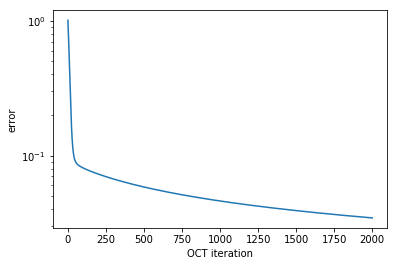

In [22]:
plot_convergence(oct_result)

We have used here that the return value of the routine `print_fidelity` that was passed to the `optimize_pulses` routine as an `info_hook` is automatically accumulated in `result.info_vals`.

We also look at optimized controls and the dynamics they induce:

pump pulse amplitude and phase:


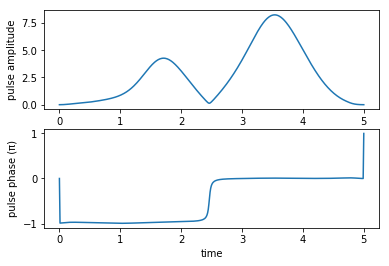

Stokes pulse amplitude and phase:


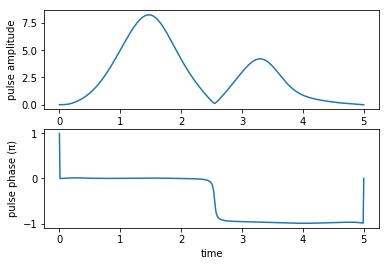

In [23]:
print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist)

In [24]:
opt_dynamics = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3])
opt_states = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm)

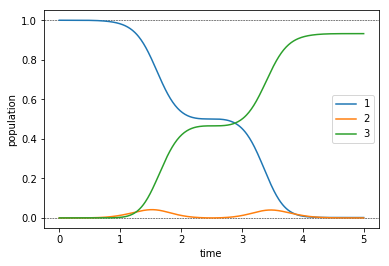

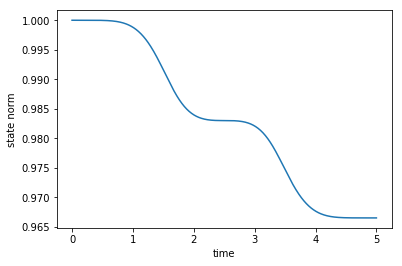

In [25]:
plot_population(opt_dynamics)
plot_norm(opt_states)

In accordance with the lower optimization error, the population dynamics now show
a reasonably efficient transfer, and a significantly reduced population in
state $\ket{2}$.

Finally, we can convert the complex-valued $\Omega_P$ and $\Omega_S$ functions to the
physical electric fields $\epsilon_{P}$ and $\epsilon_{S}$:

Physical electric pump pulse in the lab frame:


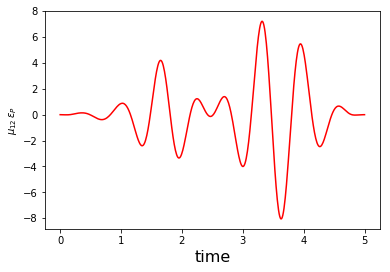

Physical electric Stokes pulse in the lab frame:


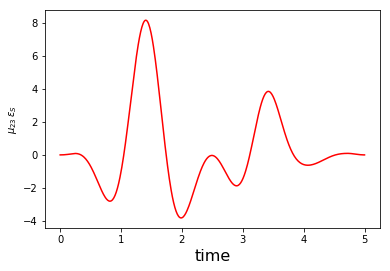

In [26]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w = 9.5
    elif case == 'stokes':
        w = 4.5
    else:
        print('Error: selected case is not a valid option')
        return

    ax = plt.subplot(111)
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
    elif case == 'stokes':
        ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
    plt.show()


print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist, case = 'stokes')